<a href="https://colab.research.google.com/github/EricDeop/NLP--Spacy-Preprocessing-/blob/Male-Comments/Male_Comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

import numpy as np
import pandas as pd

path = "/content/drive/MyDrive/LeaderComment.csv"

df = pd.read_csv(path)

df.head()

Mounted at /content/drive


,SURVEYRESPONDERID,AVERAGE_RESPONSE_DATE,YEAR,MONTH,GENDER,SURVEYQUESTIONESSENCEID,COMMENT
0,17296164,1/7/21,2021,1,Male,30013,Melvins professional demeanor and interpersona...
1,17311889,1/7/21,2021,1,Female,30014,Proved better supervision and support.
2,17334983,1/7/21,2021,1,Male,30013,Proven experience
3,17340598,1/2/21,2021,1,Male,30014,"Let the team do what they were hired to do, so..."
4,17340874,1/2/21,2021,1,Male,30013,They consistently look for opportunities to ma...


In [2]:
#Importing necessary packages
import spacy
import re
import string
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline

#Data Cleaning before splitting dataset to only male gender

In [3]:
df['GENDER'] = df['GENDER'].str.lower()

df = df.replace({'GENDER' : {'do not wish to disclose' : 'prefer not to answer',
                        'cisgender' : 'gender not listed', 'm' : 'male', 
                        'f' : 'female'}})

df = df[df["GENDER"].str.contains(
    "non-binary|other gender|gender not listed|gender identity not listed|other gender"
    ) == False]

print("\n")

df['GENDER'].value_counts()

female                  96071
male                    84840
prefer not to answer    24326
Name: GENDER, dtype: int64

In [4]:
#Removing duplicates
#Survey responder ID - Duplicate survey ID indicates same person
#cannot ascertain if duplicate comments exist that they are from the same person
#left comments as is and the other columns too

ids = df['SURVEYRESPONDERID']
duplicates = ids[ids.duplicated()]

print("Duplicate ID's :", duplicates.value_counts().sum(),"\n")

df = df.drop_duplicates(subset=['SURVEYRESPONDERID'])
print("Rows, Columns after Duplicate ID's removed: ",df.shape)

Duplicate ID's : 24 

Rows, Columns after Duplicate ID's removed:  (205213, 7)


In [5]:
# Removing Nan Values

print(df.isna().sum().sort_values(ascending = False))

#NaN values only found in comment column
#Removal of those 4 comments
df = df.dropna()

df.shape

# Dropping AVERAGE_RESPONSE_DATE, YEAR, and MONTH columns as they will 
# not be relevant to this analysis

df = df.drop(columns=['AVERAGE_RESPONSE_DATE', 'YEAR', 'MONTH'], axis=1)
df.head()

COMMENT                    4
SURVEYRESPONDERID          0
AVERAGE_RESPONSE_DATE      0
YEAR                       0
MONTH                      0
GENDER                     0
SURVEYQUESTIONESSENCEID    0
dtype: int64


,SURVEYRESPONDERID,GENDER,SURVEYQUESTIONESSENCEID,COMMENT
0,17296164,male,30013,Melvins professional demeanor and interpersona...
1,17311889,female,30014,Proved better supervision and support.
2,17334983,male,30013,Proven experience
3,17340598,male,30014,"Let the team do what they were hired to do, so..."
4,17340874,male,30013,They consistently look for opportunities to ma...


In [6]:
# Converting all text to lowercase and removing punctuations

def clean_text(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]',' ', text)
  text = re.sub('\[.*?\#]', '', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  return text

cleaning = lambda x: clean_text(x)

In [7]:
df_clean = pd.DataFrame(df['COMMENT'].apply(cleaning))

df["COMMENT"] = df_clean

print(df['COMMENT'].head(10),"\n")
print(df['COMMENT'].tail(10))

0    melvins professional demeanor and interpersona...
1               proved better supervision and support 
2                                   proven experience 
3    let the team do what they were hired to do  so...
4    they consistently look for opportunities to ma...
5    willingness to terminate bad employees  commit...
6    calm  fearless  godliness of character  respec...
7    it doesnt  you have a manager that wife works ...
8    quit pitting the different shifts and departme...
9    pay me what i deserve based on my qualificatio...
Name: COMMENT, dtype: object 

206951               good at communicating what is required
206952                 employ composite industry managers  
206953                        drug test and stick to policy
206954                     passion and drive for results   
206955    spend money in the right areas   stop employin...
206956    his open and willingness to describe what is g...
206957    howard makes sure that we feel safe and feel c...

In [8]:
#Splitting Original data to only MALE under GENDER column

male = df[df["GENDER"].str.match("male") == True]

male.head()

,SURVEYRESPONDERID,GENDER,SURVEYQUESTIONESSENCEID,COMMENT
0,17296164,male,30013,melvins professional demeanor and interpersona...
2,17334983,male,30013,proven experience
3,17340598,male,30014,let the team do what they were hired to do so...
4,17340874,male,30013,they consistently look for opportunities to ma...
5,17341537,male,30013,willingness to terminate bad employees commit...


In [9]:
# Splitting MALE gender by SURVEYQUESTIONESSENCEID

male_inspire = male[male["SURVEYQUESTIONESSENCEID"] == 30013]
male_gain = male[male["SURVEYQUESTIONESSENCEID"] == 30014]


print(male_inspire.iloc[[0,1,2,3,4],[1,2]], "\n")
print(male_gain.iloc[[0,1,2,3,4],[1,2]])

   GENDER  SURVEYQUESTIONESSENCEID
0    male                    30013
2    male                    30013
4    male                    30013
5    male                    30013
13   male                    30013 

   GENDER  SURVEYQUESTIONESSENCEID
3    male                    30014
9    male                    30014
21   male                    30014
22   male                    30014
25   male                    30014


#TOKENIZATION

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

male_inspire_words = list(sent_to_words(male_inspire["COMMENT"]))

male_gain_words = list(sent_to_words(male_gain["COMMENT"]))

print(male_inspire_words[:1],"\n")

print(male_gain_words[:1])

[['melvins', 'professional', 'demeanor', 'and', 'interpersonal', 'skills', 'inspire', 'confidence']] 

[['let', 'the', 'team', 'do', 'what', 'they', 'were', 'hired', 'to', 'do', 'sometimes', 'it', 'feels', 'like', 'the', 'leaders', 'have', 'fomo', 'or', 'an', 'have', 'to', 'do', 'it', 'for', 'it', 'to', 'be', 'done', 'right', 'mentality']]


#Forming Bigrams in Datasets

In [11]:
#Bigrams

inspire_bigram = gensim.models.Phrases(male_inspire_words, min_count=3,threshold=10)

gain_bigram = gensim.models.Phrases(male_gain_words, min_count=3,threshold=20)

In [12]:
bigram_mod_inspire = gensim.models.phrases.Phraser(inspire_bigram)

bigram_mod_gain = gensim.models.phrases.Phraser(gain_bigram)

In [13]:
def make_inspire_bigrams(texts):
    return [bigram_mod_inspire[doc] for doc in texts]

def make_gain_bigrams(texts):
    return [bigram_mod_gain[doc] for doc in texts]

male_inspire_words = make_inspire_bigrams(male_inspire_words)

male_gain_words = make_gain_bigrams(male_gain_words)

In [14]:
print(male_inspire_words[0])

print(male_gain_words[0])

['melvins', 'professional', 'demeanor', 'and', 'interpersonal', 'skills', 'inspire_confidence']
['let', 'the', 'team', 'do', 'what', 'they', 'were_hired', 'to', 'do', 'sometimes', 'it', 'feels_like', 'the', 'leaders', 'have', 'fomo', 'or', 'an', 'have', 'to', 'do', 'it', 'for', 'it', 'to', 'be', 'done', 'right', 'mentality']


In [15]:
print(len(male_inspire_words))
print(len(male_gain_words))

49883
34952


#Removing Stop Words with manual list added and removal of bigrams from dataset

In [16]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

nlp = spacy.load('en_core_web_lg', disable = ['parser','ner'])

print(nlp.Defaults.stop_words)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
{'elsewhere', 'up', 'last', 'this', 'seeming', 'himself', 'which', 'however', 'therefore', 'a', 'since', 'again', "'d", 'between', 'for', 'others', 'anyone', 'besides', 'you', 'bottom', 'whence', 'except', 'otherwise', 'though', 'ten', 'amongst', 'yet', 'not', 'it', 'indeed', 'through', '‘re', 'the', 'very', 'both', 'she', 'someone', 'than', 'does', 'hereby', 'two', 'without', 'somewhere', 'always', '‘ve', 'together', 'above', 'used', 'beyond', 'either', 'via', 'eleven', 'more', 'none', 'other', 'be', 'such', "'re", 'become', 'twelve', '’re', 'own', '’m', 'thru', 'formerly', 'him', 'most', 'because', 'down', 'to', 'thereby', 'therein', 'but', 'was', 'three', 'by', 'we', 'former', 'why', 'serious', 'if', 'noone', 'could', 'although', 'am', 'behind', 'hereafter', 'his', 'neither', 'their', 'almost', 'were', 'n‘t', 'nowhere', 'done', 'five', 'as', 'been', 'eight', 'your', 'has', 'herein', 

In [17]:
#Adding my own stop words to list to get a better topic model

nlp.Defaults.stop_words |= {'employee','employees', 'company', 'work', 'people', 'like', 
                            'feel', 'leadership','know', 'time', 'staff', 
                            'better', 'leader', 'good', 'team', 'don','confidence',
                            'great', 'ceo', 'care', 'new', 'job', 'business',
                            'things', 'listen', 'decisions','doesn','u','come'}

In [18]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in nlp.Defaults.stop_words] for doc in texts]

In [19]:
inspire_words_nostops = remove_stopwords(male_inspire_words)

gain_words_nostops = remove_stopwords(male_gain_words)

In [20]:
print(inspire_words_nostops[0])

['melvins', 'professional', 'demeanor', 'interpersonal', 'skills']


In [21]:
#Making bigrams with data set with not stop words

inspire_nostops_bigrams = make_inspire_bigrams(inspire_words_nostops)

gain_nostops_bigrams = make_gain_bigrams(gain_words_nostops)

In [22]:
print(inspire_nostops_bigrams[0:5],"\n")
      
print(gain_nostops_bigrams[0:5]) 

[['melvins', 'professional', 'demeanor', 'interpersonal', 'skills'], ['proven', 'experience'], ['consistently', 'look', 'opportunities', 'market', 'es', 'brand', 'look', 'ways', 'improve'], ['willingness', 'terminate', 'bad', 'commitment', 'standard', 'maintaining'], ['willing', 'help']] 

[['let', 'were_hired', 'feels_like', 'leaders', 'fomo', 'right', 'mentality'], ['pay', 'deserve', 'based', 'qualifications', 'stop_treating', 'an_intern'], ['stick'], ['circumstances', 'facing', 'best'], ['expected', 'communication', 'isn']]


# Lemmatization

In [23]:
def lemmatization(texts, allowed_postags=['NOUN','ADJ', 'VERB','ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

inspire_final_words = lemmatization(inspire_nostops_bigrams, allowed_postags = [
    'NOUN','ADJ', 'VERB','ADV'])

gain_final_words = lemmatization(gain_nostops_bigrams, allowed_postags = [
    'NOUN','ADJ', 'VERB','ADV'])

print(inspire_final_words[:1])
print(gain_final_words[:1])

[['melvin', 'professional', 'demeanor', 'interpersonal', 'skill']]
[['let', 'were_hired', 'feels_like', 'leader', 'mentality']]


#EDA

In [24]:
long_list_inspire = [item for sublist in inspire_final_words for item in sublist]   

long_list_gain = [item for sublist in gain_final_words for item in sublist]   

In [25]:
from nltk import word_tokenize, pos_tag
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def vb_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_vb_adj = lambda pos: pos[:2] == 'VB' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    all_vbs_adj = [word for (word, pos) in pos_tag(tokenized) if is_vb_adj(pos)]
    return ' '.join(all_vbs_adj) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [26]:
long_string_inspire = ' '.join(long_list_inspire)

long_string_gain = ' '.join(long_list_gain)

In [27]:
inspire_verbs_adj = vb_adj(long_string_inspire)

inspire_verbs_adj_tokens = word_tokenize(inspire_verbs_adj)

gain_verbs_adj = vb_adj(long_string_gain)

gain_verbs_adj_tokens = word_tokenize(gain_verbs_adj)

In [28]:
print(inspire_verbs_adj_tokens[:4])
print(gain_verbs_adj_tokens[:4])

['melvin', 'professional', 'interpersonal', 'prove']
['let', 'were_hired', 'feels_like', 'pay']


In [29]:
print(len(inspire_verbs_adj_tokens))

print(len(gain_verbs_adj_tokens))

92364
108620


In [30]:
from nltk.probability import FreqDist

fd_inspire = FreqDist(inspire_verbs_adj_tokens)

fd_gain = FreqDist(gain_verbs_adj_tokens)

print(fd_inspire.tabulate(50))
print(fd_gain.tabulate(50))

         want          open       believe          make          good        strong      positive         think       willing          grow    understand          know          take            go          need        future     confident          hard  approachable         clear       genuine          give        honest      continue       improve        listen         right       provide          lead    individual      pandemic       succeed         smart           see          keep         speak    successful          easy knowledgeable           get      personal    personable          hear          come          able       overall     important         build           set          look 
         1537          1500          1406          1291          1192          1170          1131          1055           985           953           898           875           832           821           791           761           742           695           695           670           657      

Text(0.5, 1.0, "Males TOP 50 words\n--Survey Essence ID: 30013--\n Question: 'What about the leader\n of this company\n inspires your confidence?'")

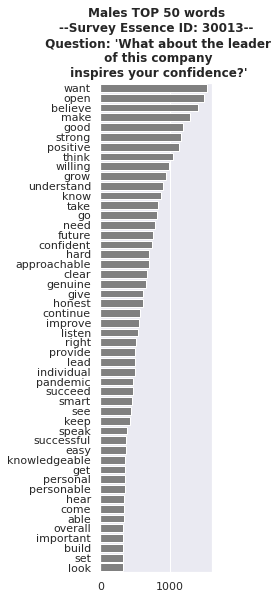

In [31]:
import seaborn as sns
sns.set_theme(style="ticks")
top_inspire = fd_inspire.most_common(50)

fdist_inspire = pd.Series(dict(top_inspire))

sns.set(rc = {'figure.figsize':(2,9)})

male_inspire = sns.barplot(y=fdist_inspire.index, x=fdist_inspire.values, color='grey')
male_inspire.set_title("Males TOP 50 words\n--Survey Essence ID: 30013--\n Question: 'What about the leader\n of this company\n inspires your confidence?'", weight='bold')

Text(0.5, 1.0, "Males TOP 50 words\n--Survey Essence ID: 30014--\n Question: 'What could the leader of\n this company do to\n gain your full confidence?'")

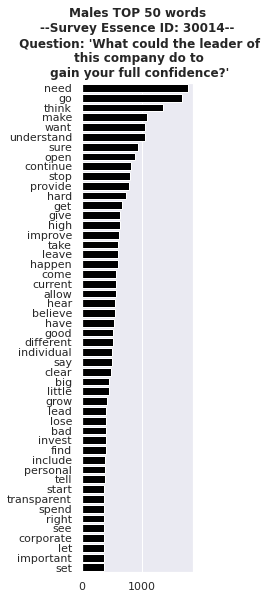

In [32]:
sns.set_theme(style="ticks")
top_gain = fd_gain.most_common(50)

fdist_gain = pd.Series(dict(top_gain))

sns.set(rc = {'figure.figsize':(2,9)})
male_gain = sns.barplot(y=fdist_gain.index, x=fdist_gain.values, color='black')
male_gain.set_title("Males TOP 50 words\n--Survey Essence ID: 30014--\n Question: 'What could the leader of\n this company do to\n gain your full confidence?'",weight='bold')

In [33]:
print(sum(fdist_inspire.values[:50]))
print(sum(fdist_gain.values[:50]))

33015
31131


In [34]:
top_50_inspire = fd_inspire.most_common(50)
top_50_gain = fd_gain.most_common(50)

fdist_50_inspire = pd.Series(dict(top_50_inspire))
fdist_50_gain = pd.Series(dict(top_50_gain))


print(fdist_50_inspire.index[:50])
print(fdist_50_gain.index[:50])

Index(['want', 'open', 'believe', 'make', 'good', 'strong', 'positive',
       'think', 'willing', 'grow', 'understand', 'know', 'take', 'go', 'need',
       'future', 'confident', 'hard', 'approachable', 'clear', 'genuine',
       'give', 'honest', 'continue', 'improve', 'listen', 'right', 'provide',
       'lead', 'individual', 'pandemic', 'succeed', 'smart', 'see', 'keep',
       'speak', 'successful', 'easy', 'knowledgeable', 'get', 'personal',
       'personable', 'hear', 'come', 'able', 'overall', 'important', 'build',
       'set', 'look'],
      dtype='object')
Index(['need', 'go', 'think', 'make', 'want', 'understand', 'sure', 'open',
       'continue', 'stop', 'provide', 'hard', 'get', 'give', 'high', 'improve',
       'take', 'leave', 'happen', 'come', 'current', 'allow', 'hear',
       'believe', 'have', 'good', 'different', 'individual', 'say', 'clear',
       'big', 'little', 'grow', 'lead', 'lose', 'bad', 'invest', 'find',
       'include', 'personal', 'tell', 'start', '

In [35]:
inspire_top_50 = ['want', 'open', 'believe', 'make', 'good', 'strong', 'positive',
       'think', 'willing', 'grow', 'understand', 'know', 'take', 'go', 'need',
       'future', 'confident', 'hard', 'approachable', 'clear', 'genuine',
       'give', 'honest', 'continue', 'improve', 'listen', 'right', 'provide',
       'lead', 'individual', 'pandemic', 'succeed', 'smart', 'see', 'keep',
       'speak', 'successful', 'easy', 'knowledgeable', 'get', 'personal',
       'personable', 'hear', 'come', 'able', 'overall', 'important', 'build',
       'set', 'look']

gain_top_50 = ['need', 'go', 'think', 'make', 'want', 'understand', 'sure', 'open',
       'continue', 'stop', 'provide', 'hard', 'get', 'give', 'high', 'improve',
       'take', 'leave', 'happen', 'come', 'current', 'allow', 'hear',
       'believe', 'have', 'good', 'different', 'individual', 'say', 'clear',
       'big', 'little', 'grow', 'lead', 'lose', 'bad', 'invest', 'find',
       'include', 'personal', 'tell', 'start', 'transparent', 'spend', 'right',
       'see', 'corporate', 'let', 'important', 'set']

In [36]:
gain_inpspire_common_words = []

for word in inspire_top_50:
  if word in gain_top_50:
    gain_inpspire_common_words.append(word) 

In [37]:
print(gain_inpspire_common_words) 
print(len(gain_inpspire_common_words)) 
#WORDS ADDED TO STOPWORD LIST

['want', 'open', 'believe', 'make', 'good', 'think', 'grow', 'understand', 'take', 'go', 'need', 'hard', 'clear', 'give', 'continue', 'improve', 'right', 'provide', 'lead', 'individual', 'see', 'get', 'personal', 'hear', 'come', 'important', 'set']
27


In [38]:
nlp.Defaults.stop_words |= {'want', 'open', 'believe', 'make', 'good', 'think',
                            'grow', 'understand', 'take', 'go', 'need', 'hard',
                            'clear', 'give', 'continue', 'improve', 'right', 
                            'provide', 'lead', 'individual', 'see', 'get',
                            'personal', 'hear', 'come', 'important', 'set',
                            'big','happen','look','live','sure',
                            'real','stop','allow','current','little','different',
                            'try','confident','big','try','right','live','current',
                            'sure','run','little','allow','high',
                            'bad','different','start','lead','real',
                            'bring','hold','true','set','different','inspire','hold',
                            'stop','little','follow','high','allow',
                            'real','look','bad','expect','focus','present',
                            'let','find','tell','start','ask','invest','big',
                            'actual','actually'}

In [39]:
#stopwords removed after lemmatization and implementing common
#word between datasets

inspire_final_verbs_adj = remove_stopwords(inspire_verbs_adj_tokens)

gain_final_verbs_adj = remove_stopwords(gain_verbs_adj_tokens)

# Creating corpus for Topic Modeling

In [40]:
id2inspire = corpora.Dictionary(inspire_final_verbs_adj)

id2gain = corpora.Dictionary(gain_final_verbs_adj)

inspire_texts = inspire_final_verbs_adj

gain_texts = gain_final_verbs_adj

inspire_corpus = [id2inspire.doc2bow(text) for text in inspire_texts]

gain_corpus = [id2gain.doc2bow(text) for text in gain_texts]

print(inspire_corpus[:1])
print(gain_corpus[:1])

[[(0, 1)]]
[[]]


In [41]:
lda_inspire_model = gensim.models.ldamodel.LdaModel(corpus=inspire_corpus,
                                           id2word=id2inspire,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=3,
                                           alpha='auto',
                                           per_word_topics=True)


lda_gain_model = gensim.models.ldamodel.LdaModel(corpus=gain_corpus,
                                           id2word=id2gain,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=3,
                                           alpha='auto',
                                           per_word_topics=True)

# Male topics for those who answered

# **"What about the leader of this company inspires your confidence?"**

In [42]:
pprint(lda_inspire_model.print_topics())
doc_inspire_lda = lda_inspire_model[inspire_corpus]

[(0,
  '0.028*"approachable" + 0.027*"willing" + 0.020*"honest" + 0.014*"smart" + '
  '0.013*"knowledgeable" + 0.010*"financial" + 0.009*"update" + 0.009*"drive" '
  '+ 0.009*"successful" + 0.009*"available"'),
 (1,
  '0.035*"strong" + 0.030*"positive" + 0.024*"future" + 0.022*"genuine" + '
  '0.013*"overall" + 0.013*"succeed" + 0.012*"personable" + 0.011*"thoughtful" '
  '+ 0.011*"easy" + 0.009*"involve"')]


# Male topics for those who answered

# **"What could the leader of this company do to gain your full confidence?"**

In [43]:
pprint(lda_gain_model.print_topics())
doc_gain_lda = lda_gain_model[gain_corpus]

[(0,
  '0.011*"strong" + 0.011*"salary" + 0.011*"transparent" + 0.009*"build" + '
  '0.009*"direct" + 0.009*"honest" + 0.008*"help" + 0.008*"positive" + '
  '0.007*"pay" + 0.007*"wrong"'),
 (1,
  '0.015*"leave" + 0.015*"spend" + 0.010*"raise" + 0.010*"include" + '
  '0.008*"lose" + 0.008*"future" + 0.008*"political" + 0.007*"low" + '
  '0.007*"corporate" + 0.007*"affect"')]


# DATA VISUALIZATIONS

In [44]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 15.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=16470e481522f6834c26bc6edd13fd0a45807e51552b3882a78577f692d1593d
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [45]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
inspire_vis = pyLDAvis.gensim_models.prepare(lda_inspire_model, inspire_corpus, id2inspire)
inspire_vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.114962  0.0       1        1  50.459831
0     -0.114962  0.0       2        1  49.540169, topic_info=             Term         Freq        Total Category  logprob  loglift
6          strong  1115.000000  1115.000000  Default  30.0000  30.0000
25       positive   956.000000   956.000000  Default  29.0000  29.0000
58   approachable   856.000000   856.000000  Default  28.0000  28.0000
5         willing   847.000000   847.000000  Default  27.0000  27.0000
222        future   748.000000   748.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
198    consistent   228.043119   239.118488   Topic2  -4.9143   0.6550
494         drive   269.634949   301.906281   Topic2  -4.7468   0.5893
129          fair   157.823811   168.002850   Topic2  -5.2824   0.6399
329    innovative   144.559298   149.695373   Topic2  -5.3702   0.6675
135          nice   171.483674   309.246415   Topic2  -5.1994   0.1127

[110 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
224       1  0.992665          able
224       2  0.004890          able
298       1  0.983311       achieve
298       2  0.017151       achieve
100       1  0.010639  always_looke
...     ...       ...           ...
5         2  0.998068       willing
259       1  0.964999           win
259       2  0.034464           win
431       1  0.968819    work_ethic
431       2  0.030514    work_ethic

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [46]:
gain_vis = pyLDAvis.gensim_models.prepare(lda_gain_model, gain_corpus, id2gain)
gain_vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.097032  0.0       1        1  50.513552
0     -0.097032  0.0       2        1  49.486448, topic_info=            Term        Freq       Total Category  logprob  loglift
248        leave  562.000000  562.000000  Default  30.0000  30.0000
142        spend  562.000000  562.000000  Default  29.0000  29.0000
170       salary  411.000000  411.000000  Default  28.0000  28.0000
380       strong  420.000000  420.000000  Default  27.0000  27.0000
107  transparent  386.000000  386.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
680       expand  209.187751  251.583851   Topic2  -5.1649   0.5189
805       social  199.345844  236.245768   Topic2  -5.2131   0.5336
375   initiative  173.666030  192.670957   Topic2  -5.3510   0.5996
593      address  182.764916  224.289707   Topic2  -5.2999   0.4987
515      promote  180.513994  233.446057   Topic2  -5.3123   0.4463

[109 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
152       1  0.992983         able
152       2  0.003940         able
35        1  0.004567  accountable
35        2  0.995581  accountable
40        1  0.010160  acknowledge
...     ...       ...          ...
178       2  0.985591      willing
167       1  0.989958          win
167       2  0.009850          win
6         1  0.007544        wrong
6         2  0.991981        wrong

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [47]:
pyLDAvis.save_html(inspire_vis, 'Male_inspire.html')
pyLDAvis.save_html(gain_vis, 'Male_gain.html')

#WORD CLOUDS

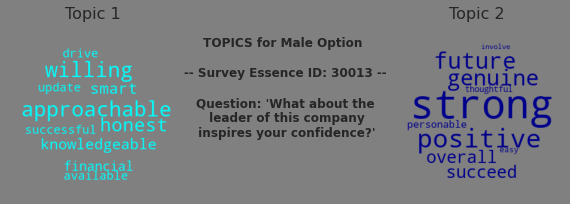

In [48]:
import matplotlib.colors as mcolors
from wordcloud import WordCloud


colsi = [color for name, color in mcolors.CSS4_COLORS.items()]

x, y = np.ogrid[:290, :290]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

cloud_inspire = WordCloud(background_color='gray',
                  width=500,
                  height=500,
                  max_words=10,
                  mask=mask,
                  color_func=lambda *args, **kwargs: colsi[i+20],
                  prefer_horizontal=1.0)

topics = lda_inspire_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(14,3), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud_inspire.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud_inspire)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

fig.patch.set_facecolor('grey')
fig.suptitle("TOPICS for Male Option \n\n-- Survey Essence ID: 30013 --\n\nQuestion: 'What about the\n leader of this company\n inspires your confidence?'",
             fontweight='bold',y=0.8,fontsize=12)

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

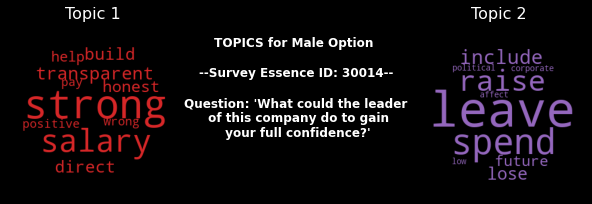

In [49]:
colsd = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud_gain = WordCloud(background_color='black',
                  width=500,
                  height=500,
                  max_words=100,
                  mask=mask,
                  color_func=lambda *args, **kwargs: colsd[i+3],
                  prefer_horizontal=1.0)

topics = lda_gain_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(15,3), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud_gain.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud_gain)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16), color='white')
    plt.gca().axis('off')

fig.patch.set_facecolor('black')
fig.suptitle("TOPICS for Male Option \n\n--Survey Essence ID: 30014--\n\nQuestion: 'What could the leader\n of this company do to gain\n your full confidence?'",
             fontweight='bold',y=0.8,fontsize=12, color='white')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()